Currently I have two algorithms for finding the best focus plane.
FULL STACK:
Gets a prediction for every image in the stack, collects all planes for which the model predicts "acceptable" and then takes the median plane out of the acceptable focus list.
FUNNEL:
Defines an upper and lower bound, which start at 0 and 44. With each image for which a prediction is generated these bounds are updated. The loop ends when either the model predicts acceptable OR when the upper and lower bounds converge.

In [12]:
# Import libraries
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from pathlib import Path
import statistics

# Define functions
def get_prediction(image_path, means, stds):
	# Imports and processes an image, then passes it to the model to generate a prediction
	with torch.no_grad():
		image = process_image(image_path, means, stds)
		image.unsqueeze_(0) # Unsqueeze to add a "dummy" dimension - this would be the batch size in a multi image set
		
		model_start = time.time()
		output = model(image)
		model_end = time.time()

		# Convert the output to the top prediction
		_, prediction_index = torch.max(output.data, 1)
		
		# Conver the index, which is a tensor, into a numpy array
		prediction = torch.Tensor.numpy(prediction_index)
		# Get the value out of the numpy array
		prediction = prediction.item()

	# The focus classes are indicated by numbers, so the index is equivalent to the class name
	return prediction, model_start, model_end

def find_best_full_stack(focus_stack):
    # Start logging time
    start = time.time()
    
    plane_range = [0, 44]
    # Set means and stds for the model
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    # Means and stds for Resnet50, update these if using a different model
    
    # Index for the class "acceptabe" - images that are in focus. This index will change based on how
    # many classes the classifer has
    acceptable = 2
    
    prediction_list = []
    plane_list = list(range(plane_range[0], (plane_range[1] + 1)))

    model_starts = []
    model_ends = []
    
    for current_plane in plane_list: # Iterate through every image in the stack
        # Get an image
        # For now this is pulled from a focus stack using the plane to specify the file name
        if current_plane > 9:
            image_file = str(int(current_plane)) + '.png'
        else:
            image_file = '0' + str(int(current_plane)) + '.png'
        image_path = focus_stack / image_file
    
        prediction, model_start, model_end = get_prediction(image_path, means, stds)
        model_starts.append(model_start)
        model_ends.append(model_end)
        
        # Capture the current plane + prediction
        prediction_list.append(prediction)

    # Use the plane and prediction list to get the median plane with an acceptable focus
    acceptable_planes = []
    for i in range(len(plane_list)):
        if prediction_list[i] == acceptable:
            acceptable_planes.append(plane_list[i])
    
    # Take the median acceptable focus plane as the best
    best_focus = statistics.median(acceptable_planes)
    # Stop logging execution time
    end = time.time()
    run_time = end - start

    model_time = np.array(model_ends) -np.array(model_starts)
    model_time = np.sum(model_time)

    return best_focus, run_time, model_time

In [13]:
%%capture
# Load the pre-trained model
model_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/resnet50_5cat_unbiased.pth'
model = torch.load(model_path)
model.eval() # Put the model in eval mode


In [14]:
import os
# Set a directory to search in
experiment_dir = Path('/Volumes/purplearray/Pittman_Will/20190521_cyclo_dead/')

chosen_list = []
found_list = []
run_times = []
model_times = []

total = 0
correct = 0

# Iterate through all sub directories looking for best_focus.txt files.
for worm in os.listdir(experiment_dir):
    worm_dir = experiment_dir / worm

    for stack in worm_dir.glob('* focus'):
        stack_dir = worm_dir / stack

        q = stack_dir / 'best_focus.txt'
        # Check if best focus has been noted for this stack
        if q.exists():
            total += 1
            # Read the filename of the best focus image out of the textfile, then convert the
            # filename (ex. 20.png) into an integer
            best_focus = int(str(q.read_text()).split('.')[0])
            chosen_list.append(best_focus)

            # Run find_best in stack_dir to see which image the model selects
            found_focus, run_time, model_time = find_best_full_stack(stack_dir)
            found_list.append(found_focus)
            run_times.append(run_time)
            model_times.append(model_time)

            if found_focus in [(best_focus - 1), best_focus, (best_focus + 1)]:
                correct += 1

percent_correct = correct / total * 100
avg_run_time = statistics.mean(run_times)
avg_model_time = statistics.mean(model_times)

print('Percent within one plane of best focus (manual): ' + str(percent_correct) + ' %')
print('Average run time: ' + str(avg_run_time))
print('Average for model prediction: ' + str(avg_model_time))

Percent within one plane of best focus (manual): 25.64102564102564 %
Average run time: 15.331356598780705
Average for model prediction: 2.861762211872981


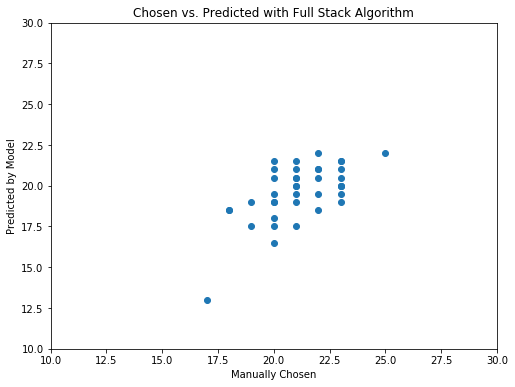

In [18]:
# Make a scatter plot to view chosen vs. predicted best focus
%matplotlib inline
fig=plt.figure(figsize=(8, 6))
plt.scatter(chosen_list, found_list)
plt.title('Chosen vs. Predicted with Full Stack Algorithm')
plt.xlabel('Manually Chosen')
plt.xlim(10, 30)
plt.ylim(10, 30)
plt.ylabel('Predicted by Model')
plt.show()

The rate of correct predictions with the full stack model is not very good at 25%. The scatter plot shows that all the errors seem to invole a predicted best focus plane that is higher than the chosen best focus plane (ex. 22 when the best focus is at 20)

In [31]:
# Define functions for the funnel algorithm
# Import libraries
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from pathlib import Path

# Define functions
def get_prediction(image_path, means, stds):
    # Imports and processes an image, then passes it to the model to generate a prediction
    with torch.no_grad():
        image = process_image(image_path, means, stds)
        image.unsqueeze_(0) # Unsqueeze to add a "dummy" dimension - this would be the batch size in a multi image set
        
        model_start = time.time()
        output = model(image)
        model_end = time.time()
        
        # Convert the output to the top prediction
        _, prediction_index = torch.max(output.data, 1)
        
        # Conver the index, which is a tensor, into a numpy array
        prediction = torch.Tensor.numpy(prediction_index)
        # Get the value out of the numpy array
        prediction = prediction.item()
        
    # The focus classes are indicated by numbers, so the index is equivalent to the class name
    return prediction, model_start, model_end


def get_new_plane(upper_bound, lower_bound, current_plane, prediction):
	# Determine which focus plane to move to to get another image

	# Define a "steps dictionary" - how many steps is it from a given class to get to acceptable?
	# Goal is to slightly overshoot, so the max number of steps is given
	# The details of the steps_dict are dependent on the sorter used to class images prior to training the model
	steps_dict = {
		0 : 13, # full range / 2 + 1 
		1 : 7, # 2 x 6 steps + 1
		2 : 0, # 6 steps + 1	
		3 : -7, # Placeholder, this should never actually get called
		4 : -13
		}

	steps = steps_dict[prediction]

	if steps < 0:
		# Split the difference between the current plane and the lower bound
		new_plane = int(lower_bound + ((current_plane - lower_bound) // 2))
	else:
		# Splot the difference between the current plane and the upper bound
		 new_plane = int(upper_bound - ((upper_bound - current_plane) // 2))

	return new_plane

def find_best_funnel(focus_stack):
    # Functionalized version of find_best, searches through the stack using the model to ID best focus
    # Set the range limits for the focus stack
    
    start = time.time()
    
    plane_range = [0, 44]

    # Set means and stds for the model
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    # Means and stds for Resnet50, update these if using a different model

    # Index for the class "acceptabe" - images that are in focus. This index will change based on how
    # many classes the classifer has
    acceptable = 2

    prediction_list = []
    plane_list = []

    model_starts = []
    model_ends = []
    
    # Set the starting plane
    start_plane = 30

    upper_bound = plane_range[1]
    lower_bound = plane_range[0]

    current_plane = start_plane # Current plane is expected to be an integer
    acceptable_focus = False
    while not acceptable_focus:
        # Get an image
        # For now this is pulled from a focus stack using the plane to specify the file name
    
        if current_plane > 9:
            image_file = str(int(current_plane)) + '.png'
        else:
            image_file = '0' + str(int(current_plane)) + '.png'
        image_path = focus_stack / image_file
        
        prediction, model_start, model_end = get_prediction(image_path, means, stds)
        model_starts.append(model_start)
        model_ends.append(model_end)
        
        # Check if the image is acceptable
        if prediction == acceptable:
            acceptable_focus = True
        elif upper_bound == (lower_bound + 1):
            # Stop the loop when the boundaries converge
            acceptable_focus = True

            
        # Re-set the upper or lower bound
        elif prediction < acceptable: # The focus plane is below the best focus plane
            lower_bound = current_plane
        else: # The focus plane is above the best focus plane
            upper_bound = current_plane
        
        # Capture the current plane + prediction
        prediction_list.append(prediction)
        plane_list.append(current_plane)
        
        # Use upper and lower bound + current plane to update the plane
        current_plane = get_new_plane(upper_bound, lower_bound, current_plane, prediction)
        
    # Stop logging execution time
    end = time.time()
    run_time = end - start

    model_time = np.array(model_ends) - np.array(model_starts)
    model_time = np.sum(model_time)
    
    return current_plane, run_time, model_time

In [32]:
import os
# Set a directory to search in
experiment_dir = Path('/Volumes/purplearray/Pittman_Will/20190521_cyclo_dead/')

chosen_list = []
found_list = []
run_times = []
model_times = []

total = 0
correct = 0

# Iterate through all sub directories looking for best_focus.txt files.
for worm in os.listdir(experiment_dir):
    worm_dir = experiment_dir / worm

    for stack in worm_dir.glob('* focus'):
        stack_dir = worm_dir / stack

        q = stack_dir / 'best_focus.txt'
        # Check if best focus has been noted for this stack
        if q.exists():
            total += 1
            # Read the filename of the best focus image out of the textfile, then convert the
            # filename (ex. 20.png) into an integer
            best_focus = int(str(q.read_text()).split('.')[0])
            chosen_list.append(best_focus)

            # Run find_best in stack_dir to see which image the model selects
            found_focus, run_time, model_time = find_best_funnel(stack_dir)
            found_list.append(found_focus)
            run_times.append(run_time)
            model_times.append(model_time)

            if found_focus in [(best_focus - 1), best_focus, (best_focus + 1)]:
                correct += 1

percent_correct = correct / total * 100
avg_run_time = statistics.mean(run_times)
avg_model_time = statistics.mean(model_times)

print('Percent within one plane of best focus (manual): ' + str(percent_correct) + ' %')
print('Average run time: ' + str(avg_run_time))
print('Average for model prediction: ' + str(avg_model_time))

Percent within one plane of best focus (manual): 53.84615384615385 %
Average run time: 1.4329052766164143
Average for model prediction: 0.3003736092494084


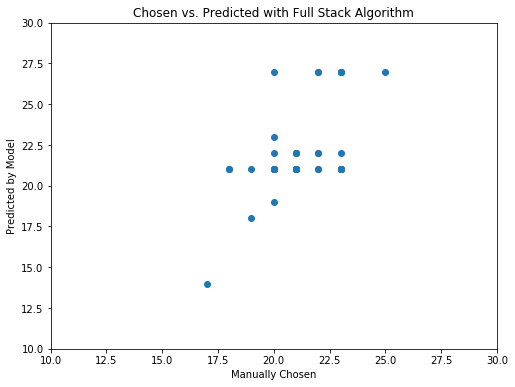

In [33]:
# Make a scatter plot to view chosen vs. predicted best focus
%matplotlib inline
fig=plt.figure(figsize=(8, 6))
plt.scatter(chosen_list, found_list)
plt.title('Chosen vs. Predicted with Full Stack Algorithm')
plt.xlabel('Manually Chosen')
plt.xlim(10, 30)
plt.ylim(10, 30)
plt.ylabel('Predicted by Model')
plt.show()

With the funnel algorithm, average run time for the algorithm drops from 15 seconds with the full stack to 1.4 seconds. Accuracy also improves to 54% from 26% with the full stack.

Considering how well the funnel algorithm works, test it using the 3 cat super biased classifier. What kind of accuracy does this lead to?

In [35]:
# Define functions for the funnel algorithm
# Import libraries
# Import the image processing functions and class
from image_import import process_image, de_process_image, wormDataset

# Import all needed libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time
from pathlib import Path

# Define functions
def get_prediction(image_path, means, stds):
    # Imports and processes an image, then passes it to the model to generate a prediction
    with torch.no_grad():
        image = process_image(image_path, means, stds)
        image.unsqueeze_(0) # Unsqueeze to add a "dummy" dimension - this would be the batch size in a multi image set
        
        model_start = time.time()
        output = model(image)
        model_end = time.time()
        
        # Convert the output to the top prediction
        _, prediction_index = torch.max(output.data, 1)
        
        # Conver the index, which is a tensor, into a numpy array
        prediction = torch.Tensor.numpy(prediction_index)
        # Get the value out of the numpy array
        prediction = prediction.item()
        
    # The focus classes are indicated by numbers, so the index is equivalent to the class name
    return prediction, model_start, model_end


def get_new_plane(upper_bound, lower_bound, current_plane, prediction):
    # Determine which focus plane to move to to get another image

    # Define a "steps dictionary" - how many steps is it from a given class to get to acceptable?
    # Goal is to slightly overshoot, so the max number of steps is given
    # The details of the steps_dict are dependent on the sorter used to class images prior to training the model
    steps_dict = {
        0 : -23,
        1 : 0,
        2 : 23,
        }

    steps = steps_dict[prediction]

    if steps < 0:
        # Split the difference between the current plane and the lower bound
        new_plane = int(lower_bound + ((current_plane - lower_bound) // 2))
    else:
        # Spltt the difference between the current plane and the upper bound
        new_plane = int(upper_bound - ((upper_bound - current_plane) // 2))

    return new_plane

def find_best_funnel(focus_stack):
    # Functionalized version of find_best, searches through the stack using the model to ID best focus
    # Set the range limits for the focus stack
    
    start = time.time()
    
    plane_range = [0, 44]

    # Set means and stds for the model
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    # Means and stds for Resnet50, update these if using a different model

    # Index for the class "acceptabe" - images that are in focus. This index will change based on how
    # many classes the classifer has
    acceptable = 2

    prediction_list = []
    plane_list = []

    model_starts = []
    model_ends = []
    
    # Set the starting plane
    start_plane = 30

    upper_bound = plane_range[1]
    lower_bound = plane_range[0]

    current_plane = start_plane # Current plane is expected to be an integer
    acceptable_focus = False
    while not acceptable_focus:
        # Get an image
        # For now this is pulled from a focus stack using the plane to specify the file name
    
        if current_plane > 9:
            image_file = str(int(current_plane)) + '.png'
        else:
            image_file = '0' + str(int(current_plane)) + '.png'
        image_path = focus_stack / image_file
        
        prediction, model_start, model_end = get_prediction(image_path, means, stds)
        model_starts.append(model_start)
        model_ends.append(model_end)
        
        # Check if the image is acceptable
        if prediction == acceptable:
            acceptable_focus = True
        elif upper_bound == (lower_bound + 1):
            # Stop the loop when the boundaries converge
            acceptable_focus = True

            
        # Re-set the upper or lower bound
        elif prediction < acceptable: # The focus plane is below the best focus plane
            lower_bound = current_plane
        else: # The focus plane is above the best focus plane
            upper_bound = current_plane
        
        # Capture the current plane + prediction
        prediction_list.append(prediction)
        plane_list.append(current_plane)
        
        # Use upper and lower bound + current plane to update the plane
        current_plane = get_new_plane(upper_bound, lower_bound, current_plane, prediction)
        
    # Stop logging execution time
    end = time.time()
    run_time = end - start

    model_time = np.array(model_ends) - np.array(model_starts)
    model_time = np.sum(model_time)
    
    return current_plane, run_time, model_time

In [36]:
%%capture
# Load the pre-trained model (3 category)
model_path = '/Users/zplab/Desktop/VeraPythonScripts/vera_autofocus/compare_num_classes/resnet50_3cat.pth'
model = torch.load(model_path)
model.eval() # Put the model in eval mode


In [37]:
import os
# Set a directory to search in
experiment_dir = Path('/Volumes/purplearray/Pittman_Will/20190521_cyclo_dead/')

chosen_list = []
found_list = []
run_times = []
model_times = []

total = 0
correct = 0

# Iterate through all sub directories looking for best_focus.txt files.
for worm in os.listdir(experiment_dir):
    worm_dir = experiment_dir / worm

    for stack in worm_dir.glob('* focus'):
        stack_dir = worm_dir / stack

        q = stack_dir / 'best_focus.txt'
        # Check if best focus has been noted for this stack
        if q.exists():
            total += 1
            # Read the filename of the best focus image out of the textfile, then convert the
            # filename (ex. 20.png) into an integer
            best_focus = int(str(q.read_text()).split('.')[0])
            chosen_list.append(best_focus)

            # Run find_best in stack_dir to see which image the model selects
            found_focus, run_time, model_time = find_best_funnel(stack_dir)
            found_list.append(found_focus)
            run_times.append(run_time)
            model_times.append(model_time)

            if found_focus in [(best_focus - 1), best_focus, (best_focus + 1)]:
                correct += 1

percent_correct = correct / total * 100
avg_run_time = statistics.mean(run_times)
avg_model_time = statistics.mean(model_times)

print('Percent within one plane of best focus (manual): ' + str(percent_correct) + ' %')
print('Average run time: ' + str(avg_run_time))
print('Average for model prediction: ' + str(avg_model_time))

Percent within one plane of best focus (manual): 0.0 %
Average run time: 0.3358291479257437
Average for model prediction: 0.06161816914876302


Well, that doesn't work very well.